In [0]:
import numpy as np
import torch
from torch import nn
from copy import deepcopy, copy
import matplotlib.pyplot as plt
import gym
from collections import namedtuple
from collections import deque

In [0]:
class q_Network(nn.Module):
    def __init__(self, env, learning_rate, device='cpu'):
        super(q_Network, self).__init__()
        # Parameters of creating a neural network
        self.inputs_size = env.observation_space.shape[0]
        self.outputs_size = env.action_space.n
        self.actions = np.arange(env.action_space.n)
        self.learning_rate = learning_rate
        self.device = device    
        # Network Architecture
        self.network = nn.Sequential(
            nn.Linear(self.inputs_size, 16),nn.ReLU(),
            nn.Linear(16, 32),nn.ReLU(), 
            nn.Linear(32, 8),nn.ReLU(), 
            nn.Linear(8, self.outputs_size))   
        # Network to GPU/CPU
        if self.device != 'cpu':
            self.network.cuda()
        # Set Optimizer for the Neural Network : Adam Optimizer
        self.optimizer = torch.optim.Adam(self.parameters(),lr=self.learning_rate)
        
    def control_action(self, state, epsilon=0.05):
        # Choice of Exploration/ Exploitation
        if np.random.random() < epsilon:
            action = np.random.choice(self.actions)
        else:
            action = self.epsilon_greedy_action(state)
        return action
    
    def epsilon_greedy_action(self, state):
        # Return the epsilon greedy action 
        qvals = self.compute_q_values(state)
        eps_greed_act = torch.max(qvals, dim=-1)[1].item()
        return eps_greed_act
    
    def compute_q_values(self, state):
        if type(state) == tuple:
            state = np.array([np.ravel(s) for s in state])
        state_t = torch.FloatTensor(state).to(device=self.device)
        q_values = self.network(state_t)
        return q_values

In [0]:
class experienceReplayBuffer:
    def __init__(self, buffer_memory_size, experienced_samples):
        # Parameters for creating a Experience Replay Buffer for Exploitation
        self.memory_size = buffer_memory_size
        self.experienced_samples = experienced_samples
        self.tuples_for_buffer = namedtuple('Buffer',field_names=['state', 'action', 'reward', 'done', 'next_state'])
        self.buffer_replay_memory = deque(maxlen = buffer_memory_size)
    def sample_batch(self, batch_size=32):
        # Sample without replacement
        samples = np.random.choice(len(self.buffer_replay_memory), batch_size, replace=False)
        # Unpacking and zipping back the elements
        batch = zip(*[self.buffer_replay_memory[i] for i in samples])
        return batch
    def append(self, state, action, reward, done, next_state):
        #Append the tuple: (state, action, reward, done, next_state) to the buffer memory
        self.buffer_replay_memory.append(self.tuples_for_buffer(state, action, reward, done, next_state))
    def experienced_samples_capacity(self):
        # Compute percentage of the required number of experiences accumulated 
        precentage_occupied = len(self.buffer_replay_memory) / self.experienced_samples
        return precentage_occupied

In [0]:
# DOUBLE DEEP Q NETWORK IMPLEMENTATION
class DDQN:
    def __init__(self, env, network, buffer, epsilon=0.05, batch_size=32):
        # Parameters for DDQN Learning
        self.env = env
        self.network = network
        # Creating a Target network (copy of the Q Network for unbiased learning)
        self.target_network = deepcopy(network)
        self.buffer = buffer
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.reward_threshold = 195
        self.initialize_all_empty()
    
    def initialize_all_empty(self):
        # Initialization with empty sets and zeros for all values
        self.training_rewards = []
        self.training_loss = []
        self.update_loss = []
        self.mean_training_rewards = []
        self.replace_net_eps = []
        self.losses = []
        self.rewards = 0
        self.step_count = 0
        self.s_0 = self.env.reset()
    
    def apply_action(self, mode='exploitation'):
        # Applying the control action on the actor based on mode: Exploration/Exploitation
        if mode == 'exploration':
            action = self.env.action_space.sample()
        else:
            action = self.network.control_action(self.s_0, epsilon=self.epsilon)
            self.step_count += 1
        next_state, rew, done, _ = self.env.step(action)
        self.rewards += rew
        self.buffer.append(self.s_0, action, rew, done, next_state)
        self.s_0 = next_state.copy()
        if done:
            self.s_0 = env.reset()
        return done
        
    # DQN training
    def train(self, gamma=0.99, max_episodes=10000, batch_size=32,net_update_freq=4,net_replace_freq=2000):
        self.gamma = gamma
        # Fill up the Replay Buffer with experiences by exploration
        while self.buffer.experienced_samples_capacity() < 1:
            self.apply_action(mode='exploration')   
        ep = 0
        continue_training = True
        while continue_training:
            self.s_0 = self.env.reset()
            self.rewards = 0
            done = False
            while done == False:
                done = self.apply_action(mode='exploitation')
                # Update network for every "net_update_freq" steps
                if self.step_count % net_update_freq == 0:
                    self.update_using_loss()
                # Replace networks for every "net_replace_freq" steps
                if self.step_count % net_replace_freq == 0:
                    self.target_network.load_state_dict(self.network.state_dict())
                    self.replace_net_eps.append(ep) 
                if done:
                    ep += 1
                    self.training_rewards.append(self.rewards)
                    self.training_loss.append(np.mean(self.update_loss))
                    self.update_loss = []
                    mean_rewards = np.mean(self.training_rewards[-100:]) # Checking mean of last 100 rewards
                    self.mean_training_rewards.append(mean_rewards)
                    print("[ ---Training---Episode:",ep,"]", " Average Reward:",mean_rewards)

                    # End the training if:
                    # 1. Number of episodes > Maximum Episodes
                    # 2. The mean reward obtained by actor in past 100 steps is greater 
                    #    than the threshold (195 for Cartpole-v0)

                    if ep >= max_episodes:
                        continue_training = False
                        print('\n Training Terminated: Maximum Episodes reached')
                        break
                    if mean_rewards >= self.reward_threshold:
                        continue_training = False
                        print('\n Training Terminated: Cart Pole Problem is solved. \n Number of episodes for convergence:',ep)
                        break
                        
    def calculate_loss(self, batch):
        states, actions, rewards, dones, next_states = [i for i in batch]
        rewards_t = torch.FloatTensor(rewards).to(device=self.network.device).reshape(-1,1)
        actions_t = torch.LongTensor(np.array(actions)).reshape(-1,1).to(device=self.network.device)
        dones_t = torch.ByteTensor(dones).to(device=self.network.device)
        qvals = torch.gather(self.network.compute_q_values(states), 1, actions_t)
        
        # DDQN Trick 
        next_actions = torch.max(self.network.compute_q_values(next_states),dim=-1)[1]
        next_actions_t = torch.LongTensor(next_actions).reshape(-1,1).to(device=self.network.device)
        target_q = self.target_network.compute_q_values(next_states)
        next_q = torch.gather(target_q, 1, next_actions_t).detach()
        next_q[dones_t] = 0 
        q_desired = self.gamma * next_q + rewards_t
        loss = nn.MSELoss()(qvals, q_desired)
        return loss
    
    def update_using_loss(self):
        self.network.optimizer.zero_grad()
        batch = self.buffer.sample_batch(batch_size=self.batch_size)
        loss = self.calculate_loss(batch)
        self.losses.append(loss)
        loss.backward()
        self.network.optimizer.step()
        if self.network.device == 'cuda':
            self.update_loss.append(loss.detach().cpu().numpy())
        else:
            self.update_loss.append(loss.detach().numpy())

In [78]:
import warnings
warnings.filterwarnings("ignore")
# Create a environment
env = gym.make('CartPole-v0')
# Define Parameters for DDQN Training
GAMMA = 0.99
BUFFER_MEMORY_SIZE = 10000
EXPERIENCE_BATCH_SIZE = 1000
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
MAXIMUM_EPISODES = 5000
NETWORK_UPDATE_STEPS = 4
NETWORK_REPLACE_STEPS = 1000
# Create a buffer object
buffer = experienceReplayBuffer(buffer_memory_size=BUFFER_MEMORY_SIZE, experienced_samples=EXPERIENCE_BATCH_SIZE)
# Create a q_network object
q_net = q_Network(env, learning_rate=LEARNING_RATE)
# Create a DDQN object (agent/actor)
actor = DDQN(env, q_net, buffer) 
# Train the actor
actor.train( gamma=GAMMA, max_episodes=MAXIMUM_EPISODES, batch_size=BATCH_SIZE,net_update_freq=NETWORK_UPDATE_STEPS,net_replace_freq=NETWORK_REPLACE_STEPS)

[ ---Training---Episode: 1 ]  Average Reward: 11.0
[ ---Training---Episode: 2 ]  Average Reward: 10.5
[ ---Training---Episode: 3 ]  Average Reward: 10.666666666666666
[ ---Training---Episode: 4 ]  Average Reward: 10.5
[ ---Training---Episode: 5 ]  Average Reward: 10.2
[ ---Training---Episode: 6 ]  Average Reward: 10.166666666666666
[ ---Training---Episode: 7 ]  Average Reward: 10.142857142857142
[ ---Training---Episode: 8 ]  Average Reward: 10.125
[ ---Training---Episode: 9 ]  Average Reward: 10.0
[ ---Training---Episode: 10 ]  Average Reward: 9.9
[ ---Training---Episode: 11 ]  Average Reward: 9.818181818181818
[ ---Training---Episode: 12 ]  Average Reward: 9.75
[ ---Training---Episode: 13 ]  Average Reward: 9.846153846153847
[ ---Training---Episode: 14 ]  Average Reward: 9.928571428571429
[ ---Training---Episode: 15 ]  Average Reward: 9.933333333333334
[ ---Training---Episode: 16 ]  Average Reward: 9.9375
[ ---Training---Episode: 17 ]  Average Reward: 9.941176470588236
[ ---Training--

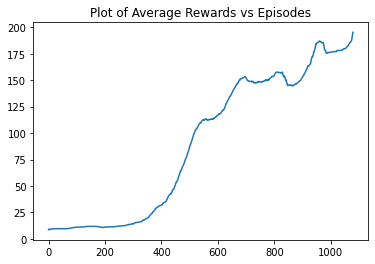

In [87]:
import matplotlib.pyplot as plt
plt.plot(agent.mean_training_rewards)
plt.title("Plot of Average Rewards vs Episodes")
plt.show()

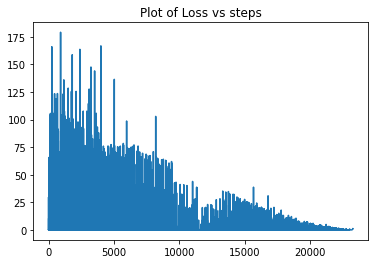

In [111]:
plt.plot(Reverse(actor.losses),label ='Training Loss')
plt.title("Plot of Loss vs steps")
plt.show()

In [0]:
# EVALUATION OF THE TRAINED AGENT 
evaluation_env = gym.make('CartPole-v0')
trajectories = []
rewards = []
# Create 100 trajectories to get get an Expectation of Reward
for i in range(100):
  state0 = evaluation_env.reset()
  traj_temp = []
  rew1 = 0
  for ts in range(200):
     act = q_net.control_action(state0)
     next_state, rew, done, _ = evaluation_env.step(act)
     traj_temp.append(rew)
     state0 = next_state
     rew1 += rew
  rewards.append(rew1)
  trajectories.append(traj_temp)

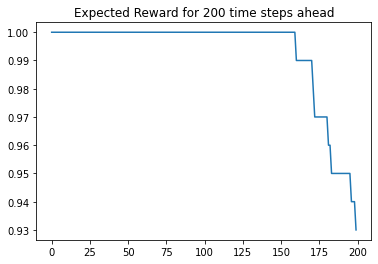

Averaged Expected Reward for 200 time steps over 100 trajectories: 198.62


In [108]:
rewar = np.mean(traj,axis = 0)
plt.plot(rewar)
plt.title("Expected Reward for 200 time steps ahead")
plt.show()
print("Averaged Expected Reward for 200 time steps over 100 trajectories:",np.mean(rewards))